# Qiskit VQE Tutorial
Full tutorial using Qiskit VQE class following
https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/algorithms/02_vqe_advanced_options.ipynb

In [74]:
import numpy as np
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import NELDER_MEAD, GradientDescent
from qiskit_nature.circuit.library.ansatzes import UCC
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit.utils import algorithm_globals
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import datetime

from qiskit import QuantumCircuit

from src.hamiltonian.FermionicHamiltonian import FermionicHamiltonian
from src.molecule.BeH2 import BeH2

In [75]:
# Hamiltonian operator creation
H2_op = SparsePauliOp.from_list(
    [
        ("IIII", -1.052373245772859),
        ("IZII", 0.39793742484318045),
        ("ZIII", -0.39793742484318045),
        ("ZZII", -0.01128010425623538),
        ("XXII", 0.18093119978423156),
    ]
)

In [76]:
H2_op.num_qubits

4

In [77]:
molecule = BeH2("test", 14, 6)

In [78]:
hamiltonian = FermionicHamiltonian(molecule.num_orbitals, molecule=molecule)
op = hamiltonian.get_hamiltonian()

In [79]:
print(len(op))

24598


In [80]:
# create estimator, optimizer, converter, ansatz
estimator = Estimator()
# optimizer definition
optimizer = NELDER_MEAD(maxiter=150, maxfev=150)
#optimizer = GradientDescent(maxiter=20)
# use UCC Ansatz
converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
#ansatz = UCC(excitations='st')

In [81]:
ucc_ansatz = UCC(qubit_converter=converter, num_spin_orbitals=14, num_particles=(0,6), excitations='sd', alpha_spin=True, beta_spin=True, max_spin_excitation=1, generalized=True, preserve_spin=True, reps=5)

In [82]:
ucc_ansatz.num_qubits
# has to be equal to the ones of the hamiltonian

14

In [83]:
ucc_ansatz_h2 = UCC(qubit_converter=converter, num_spin_orbitals=4, num_particles=(0,2), excitations='sd', alpha_spin=True, beta_spin=True, max_spin_excitation=1, generalized=True, preserve_spin=True, reps=5)

In [84]:
print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
algorithm_globals.random_seed = 50

# use ansatz TwoLocal
#ansatz2 = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
counts = []
values = []

Optimizer: NELDER_MEAD        

In [85]:
def store_intermediate_result(eval_count, parameters, mean, std):
    time = datetime.datetime.now()
    print(f"Iteration done at {time}")
    counts.append(eval_count)
    values.append(mean)

In [86]:
# TwoLocal Ansatz
ansatz = TwoLocal(num_qubits=molecule.num_orbitals, rotation_blocks="ry", entanglement_blocks="cz")
optimizer.setting

"Optimizer: NELDER_MEAD\n-- method: nelder-mead\n-- bounds_support_level: 1\n-- gradient_support_level: 1\n-- initial_point_support_level: 3\n-- options: {'maxiter': 150, 'maxfev': 150, 'disp': False, 'xatol': 0.0001, 'adaptive': False}\n-- max_evals_grouped: 1\n-- kwargs: {'tol': None}\n"

In [87]:
# Use VQE with estimator, ansatz, optimizer
vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
# invoke computation on the operator
time = datetime.datetime.now()
print(f"Starting calculation at: {time}")
result = vqe.compute_minimum_eigenvalue(operator=op)
time = datetime.datetime.now()
print(f"Ended calculation at: {time}")


converge_counts = np.asarray(counts)
converge_vals = np.asarray(values)

print("\rOptimization complete");

Starting calculation at: 2023-04-25 22:22:46.691176
Iteration done at 2023-04-25 22:22:47.879241
Iteration done at 2023-04-25 22:22:49.074251
Iteration done at 2023-04-25 22:22:50.202229
Iteration done at 2023-04-25 22:22:51.331782
Iteration done at 2023-04-25 22:22:52.495680
Iteration done at 2023-04-25 22:22:53.651416
Iteration done at 2023-04-25 22:22:54.799132
Iteration done at 2023-04-25 22:22:55.929661
Iteration done at 2023-04-25 22:22:57.095028
Iteration done at 2023-04-25 22:22:58.231503
Iteration done at 2023-04-25 22:22:59.385571
Iteration done at 2023-04-25 22:23:00.534892
Iteration done at 2023-04-25 22:23:01.676071
Iteration done at 2023-04-25 22:23:02.828356
Iteration done at 2023-04-25 22:23:03.984435
Iteration done at 2023-04-25 22:23:05.132879
Iteration done at 2023-04-25 22:23:06.269151
Iteration done at 2023-04-25 22:23:07.418244
Iteration done at 2023-04-25 22:23:08.609379
Iteration done at 2023-04-25 22:23:09.749659
Iteration done at 2023-04-25 22:23:10.887002
Ite

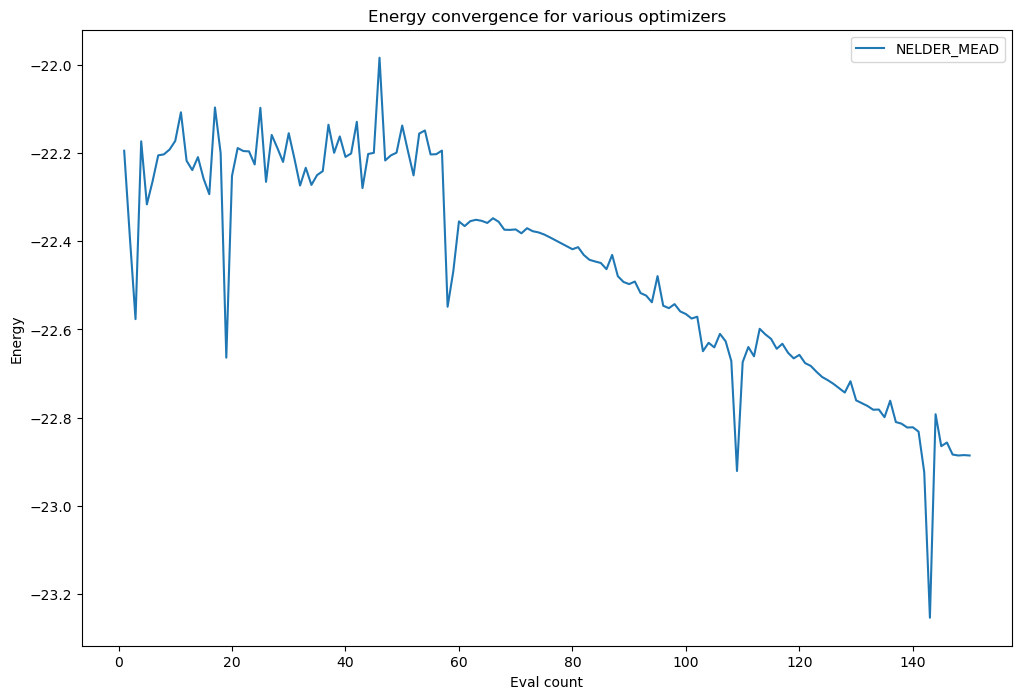

In [88]:
# Outputting the optimization process
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
pylab.plot(converge_counts, converge_vals, label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

In [89]:
# Analytic solution
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import PauliSumOp

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=op)
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -56.31553
